In [276]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


<h1> Part 1: Preprocessing and Visualizing Data </h1>
In this part we will clean the data and see how it looks in raw form and using smoothing to remove noise and be closer to the true temperature using Kalman and LOESS smoothing methods.

In [277]:
sns.set()

In [278]:
ltt_test_1 = pd.read_csv('LTTData_initial_filtering_test1.csv')
ltt_test_2 = pd.read_csv('LTTData_initial_filtering_test2.csv')
ltt_test_3 = pd.read_csv('LTTData_initial_filtering_test3.csv')
ltt_test_6 = pd.read_csv('LTTData_initial_filtering_test6.csv')
ltt_test_7 = pd.read_csv('LTTData_initial_filtering_test7.csv')
ltt_test_8 = pd.read_csv('LTTData_initial_filtering_test8.csv')

In [279]:
cols=pd.Series(ltt_test_1.columns)
for d in cols[cols.duplicated()].unique(): 
    cols[cols[cols == d].index.values.tolist()] = [d + '.' + str(i) if i != 0 else d for i in range(sum(cols == d))]

ltt_test_1.columns=cols.str.strip()

cols=pd.Series(ltt_test_2.columns)
for d in cols[cols.duplicated()].unique(): 
    cols[cols[cols == d].index.values.tolist()] = [d + '.' + str(i) if i != 0 else d for i in range(sum(cols == d))]

ltt_test_2.columns=cols.str.strip()

cols=pd.Series(ltt_test_3.columns)
for d in cols[cols.duplicated()].unique(): 
    cols[cols[cols == d].index.values.tolist()] = [d + '.' + str(i) if i != 0 else d for i in range(sum(cols == d))]

ltt_test_3.columns=cols.str.strip()

cols=pd.Series(ltt_test_6.columns)
for d in cols[cols.duplicated()].unique(): 
    cols[cols[cols == d].index.values.tolist()] = [d + '.' + str(i) if i != 0 else d for i in range(sum(cols == d))]

ltt_test_6.columns=cols.str.strip()

cols=pd.Series(ltt_test_7.columns)
for d in cols[cols.duplicated()].unique(): 
    cols[cols[cols == d].index.values.tolist()] = [d + '.' + str(i) if i != 0 else d for i in range(sum(cols == d))]

ltt_test_7.columns=cols.str.strip()

cols=pd.Series(ltt_test_8.columns)
for d in cols[cols.duplicated()].unique(): 
    cols[cols[cols == d].index.values.tolist()] = [d + '.' + str(i) if i != 0 else d for i in range(sum(cols == d))]

ltt_test_8.columns=cols.str.strip()

In [280]:
ltt_test_1

Sensor 0  Sensor 1  Sensor 2  Sensor 3  Sensor 4  Sensor 5  Sensor 6  \
0        24.58     23.18     23.36     22.92     22.75     22.31     22.92   
1        24.58     23.18     23.01     23.01     22.75     22.40     22.66   
2        24.50     23.10     23.01     22.83     22.66     22.48     22.22   
3        24.50     23.18     23.36     22.92     22.83     22.48     22.83   
4        24.50     23.18     22.75     22.92     22.75     22.48     22.48   
...        ...       ...       ...       ...       ...       ...       ...   
4894     30.31     28.40     28.40     28.22     28.13     27.95     28.22   
4895     30.13     28.49     28.40     28.22     28.22     27.68     28.31   
4896     30.22     28.40     28.40     28.31     28.13     27.86     27.95   
4897     30.22     28.40     28.40     28.22     28.22     28.04     28.40   
4898     30.22       NaN       NaN       NaN       NaN       NaN       NaN   

      Sensor 7  Sensor 0 RA  Sensor 1 RA  ...  \
0        23.27        23.55        23.15  ...   
1        23.36        23.53        23.15  ...   
2        23.36        23.50        23.15  ...   
3        23.10        23.50        23.18  ...   
4        23.36        23.50        23.18  ...   
...        ...          ...          ...  ...   
4894     28.85        29.22        28.43  ...   
4895     28.85        29.19        28.43  ...   
4896     28.85          NaN          NaN  ...   
4897     28.94          NaN          NaN  ...   
4898       NaN          NaN          NaN  ...   

      Sensor 7 RA trimmed for comparison  Sensor 0 RA.1  Sensor 1 RA .1  \
0                                  19.67          23.52           22.17   
1                                  19.67          23.51           22.16   
2                                  19.67          23.50           22.16   
3                                  19.67          23.51           22.17   
4                                  19.71          23.51           22.17   
...                                  ...            ...             ...   
4894                                 NaN            NaN             NaN   
4895                                 NaN            NaN             NaN   
4896                                 NaN            NaN             NaN   
4897                                 NaN            NaN             NaN   
4898                                 NaN            NaN             NaN   

      Sensor 2 RA .1  Sensor 3 RA .1  Sensor 4 RA.1  Sensor 5 RA .1  \
0              22.16           21.96          21.76           21.40   
1              22.10           21.96          21.76           21.42   
2              22.15           21.97          21.78           21.42   
3              22.17           22.00          21.78           21.41   
4              22.16           22.00          21.78           21.40   
...              ...             ...            ...             ...   
4894             NaN             NaN            NaN             NaN   
4895             NaN             NaN            NaN             NaN   
4896             NaN             NaN            NaN             NaN   
4897             NaN             NaN            NaN             NaN   
4898             NaN             NaN            NaN             NaN   

      Sensor 6 RA.1  Sensor 7 RA.1  TIME_RA  
0             21.65          22.27     0.00  
1             21.68          22.27     0.25  
2             21.72          22.27     0.50  
3             21.78          22.27     0.75  
4             21.76          22.31     1.00  
...             ...            ...      ...  
4894            NaN            NaN      NaN  
4895            NaN            NaN      NaN  
4896            NaN            NaN      NaN  
4897            NaN            NaN      NaN  
4898            NaN            NaN      NaN  

[4899 rows x 27 columns]

In [281]:
#sensors are placed at the inlet and outlet of every radiator
#NOTE: RA in the column names means Rolling Average. This processing was done by LTT in their original provided data.
ltt_test_1_filtered = ltt_test_1.dropna() #Hottest Radiator gets air first Sensor 0 = Hot -> Sensor 7 = Cold
ltt_test_2_filtered = ltt_test_2.dropna() #Coldest Radiator gets air first Sensor 0 = Cold -> Sensor 7 = Hot
ltt_test_3_filtered = ltt_test_3.dropna() #Unused test
ltt_test_6_filtered = ltt_test_6.dropna()
ltt_test_7_filtered = ltt_test_7.dropna()
ltt_test_8_filtered = ltt_test_8.dropna()

In [282]:
ltt_test_1_filtered

Sensor 0  Sensor 1  Sensor 2  Sensor 3  Sensor 4  Sensor 5  Sensor 6  \
0        24.58     23.18     23.36     22.92     22.75     22.31     22.92   
1        24.58     23.18     23.01     23.01     22.75     22.40     22.66   
2        24.50     23.10     23.01     22.83     22.66     22.48     22.22   
3        24.50     23.18     23.36     22.92     22.83     22.48     22.83   
4        24.50     23.18     22.75     22.92     22.75     22.48     22.48   
...        ...       ...       ...       ...       ...       ...       ...   
4883     30.22     28.40     28.49     28.22     28.22     27.77     27.95   
4884     30.22     28.40     28.31     28.22     28.22     27.77     28.31   
4885     30.22     28.40     28.40     28.31     28.13     27.95     28.04   
4886     30.22     28.40     28.58     28.49     28.22     27.95     27.95   
4887     30.22     28.49     28.58     28.22     28.04     27.86     28.49   

      Sensor 7  Sensor 0 RA  Sensor 1 RA  ...  \
0        23.27        23.55        23.15  ...   
1        23.36        23.53        23.15  ...   
2        23.36        23.50        23.15  ...   
3        23.10        23.50        23.18  ...   
4        23.36        23.50        23.18  ...   
...        ...          ...          ...  ...   
4883     28.94        29.22        28.40  ...   
4884     28.85        29.22        28.40  ...   
4885     29.21        29.22        28.43  ...   
4886     29.03        29.19        28.46  ...   
4887     28.85        29.22        28.46  ...   

      Sensor 7 RA trimmed for comparison  Sensor 0 RA.1  Sensor 1 RA .1  \
0                                  19.67          23.52           22.17   
1                                  19.67          23.51           22.16   
2                                  19.67          23.50           22.16   
3                                  19.67          23.51           22.17   
4                                  19.71          23.51           22.17   
...                                  ...            ...             ...   
4883                               25.34          29.22           27.43   
4884                               25.33          29.22           27.44   
4885                               25.34          29.22           27.43   
4886                               25.29          29.22           27.43   
4887                               25.25          29.22           27.43   

      Sensor 2 RA .1  Sensor 3 RA .1  Sensor 4 RA.1  Sensor 5 RA .1  \
0              22.16           21.96          21.76           21.40   
1              22.10           21.96          21.76           21.42   
2              22.15           21.97          21.78           21.42   
3              22.17           22.00          21.78           21.41   
4              22.16           22.00          21.78           21.40   
...              ...             ...            ...             ...   
4883           27.46           27.25          27.16           26.86   
4884           27.45           27.26          27.16           26.91   
4885           27.46           27.26          27.14           26.92   
4886           27.48           27.26          27.16           26.91   
4887           27.45           27.22          27.16           26.90   

      Sensor 6 RA.1  Sensor 7 RA.1  TIME_RA  
0             21.65          22.27     0.00  
1             21.68          22.27     0.25  
2             21.72          22.27     0.50  
3             21.78          22.27     0.75  
4             21.76          22.31     1.00  
...             ...            ...      ...  
4883          27.14          27.94  1220.75  
4884          27.18          27.93  1221.00  
4885          27.14          27.94  1221.25  
4886          27.19          27.89  1221.50  
4887          27.19          27.85  1221.75  

[4888 rows x 27 columns]

In [283]:
ltt_test_1_filtered.describe()

Sensor 0     Sensor 1     Sensor 2     Sensor 3     Sensor 4  \
count  4888.000000  4888.000000  4888.000000  4888.000000  4888.000000   
mean     33.500550    31.523998    31.257946    30.969773    30.812952   
std       3.365639     3.181978     3.140712     3.150670     3.233303   
min      24.410000    22.570000    22.050000    22.750000    22.050000   
25%      31.140000    29.310000    29.210000    28.940000    28.850000   
50%      33.480000    31.510000    31.320000    31.040000    30.860000   
75%      36.180000    34.140000    33.760000    33.480000    33.380000   
max      39.730000    37.180000    36.880000    37.280000    37.580000   

          Sensor 5     Sensor 6     Sensor 7  Sensor 0 RA  Sensor 1 RA  ...  \
count  4888.000000  4888.000000  4888.000000  4888.000000  4888.000000  ...   
mean     30.406565    30.482136    31.209491    32.501702    31.525057  ...   
std       3.197551     3.219698     3.239094     3.362294     3.179113  ...   
min      22.050000    21.960000    22.920000    23.470000    22.950000  ...   
25%      28.490000    28.670000    29.400000    30.170000    29.340000  ...   
50%      30.490000    30.680000    31.410000    32.450000    31.480000  ...   
75%      32.910000    33.025000    33.760000    35.210000    34.110000  ...   
max      36.380000    36.280000    36.980000    38.380000    37.050000  ...   

       Sensor 7 RA trimmed for comparison  Sensor 0 RA.1  Sensor 1 RA .1  \
count                         4888.000000    4888.000000     4888.000000   
mean                            27.612975      32.504032       30.527216   
std                              3.232399       3.357605        3.174815   
min                             19.670000      23.490000       22.060000   
25%                             25.810000      30.160000       28.340000   
50%                             27.790000      32.450000       30.485000   
75%                             30.160000      35.210000       33.100000   
max                             32.780000      38.340000       35.980000   

       Sensor 2 RA .1  Sensor 3 RA .1  Sensor 4 RA.1  Sensor 5 RA .1  \
count     4888.000000     4888.000000    4888.000000     4888.000000   
mean        30.261234       29.973032      29.816264       29.409951   
std          3.131192        3.143392       3.224460        3.190708   
min         21.950000       21.870000      21.680000       21.370000   
25%         28.210000       27.977500      27.860000       27.500000   
50%         30.300000       30.020000      29.830000       29.520000   
75%         32.790000       32.490000      32.370000       31.930000   
max         35.510000       35.370000      35.260000       34.620000   

       Sensor 6 RA.1  Sensor 7 RA.1      TIME_RA  
count    4888.000000    4888.000000  4888.000000  
mean       29.485499      30.212975   610.875000  
std         3.205675       3.232399   352.797097  
min        21.560000      22.270000     0.000000  
25%        27.680000      28.410000   305.437500  
50%        29.650000      30.390000   610.875000  
75%        32.040000      32.760000   916.312500  
max        34.640000      35.380000  1221.750000  

[8 rows x 27 columns]

In [284]:
ltt_test_2_filtered

Sensor 0 Trimmed  Sensor 1  Sensor 1.1  Sensor 2  Sensor 3  Sensor 4  \
0                19.64     19.78       19.18     20.14     19.96     20.05   
1                19.82     19.61       19.01     20.05     19.79     19.96   
2                19.73     19.69       19.09     20.14     19.88     19.96   
3                19.56     19.69       19.09     20.14     19.70     19.79   
4                19.73     19.69       19.09     20.14     20.14     20.05   
...                ...       ...         ...       ...       ...       ...   
4776             22.87     23.17       22.57     24.06     23.71     23.88   
4777             22.87     23.35       22.75     23.97     23.79     23.88   
4778             22.96     23.17       22.57     23.97     23.71     23.88   
4779             22.87     23.26       22.66     24.06     23.71     23.88   
4780             22.87     23.17       22.57     23.97     23.71     23.79   

      Sensor 5  Sensor 6  Sensor 7  Sensor 8  ...     Time  Sensor 0 RA.1  \
0        20.31     19.88     20.22     20.05  ...     0.00          19.68   
1        19.88     19.88     19.96     20.05  ...     0.25          19.69   
2        20.05     19.88     20.05     20.05  ...     0.50          19.72   
3        19.88     19.88     20.05     20.05  ...     0.75          19.72   
4        20.05     19.88     20.14     20.05  ...     1.00          19.72   
...        ...       ...       ...       ...  ...      ...            ...   
4776     23.71     23.62     23.79     23.62  ...  1194.00          23.20   
4777     23.88     23.62     23.71     23.71  ...  1194.25          19.89   
4778     23.27     23.62     23.53     23.44  ...  1194.50          16.55   
4779     23.79     23.62     23.79     23.53  ...  1194.75          13.24   
4780     23.79     23.53     23.71     23.53  ...  1195.00           9.92   

      Sensor 1 RA.1  Sensor 2 RA.1  Sensor 3 RA .1  Sensor 4 RA.1  \
0             20.13          19.88           19.96          19.93   
1             20.13          19.87           19.95          19.90   
2             20.13          19.87           19.95          19.91   
3             20.13          19.87           19.92          19.90   
4             20.13          19.89           19.95          19.91   
...             ...            ...             ...            ...   
4776          24.02          23.80           23.79          23.72   
4777          20.58          20.41           20.38          20.33   
4778          17.16          17.01           16.97          16.92   
4779          13.74          13.62           13.56          13.59   
4780          10.30          10.24           10.15          10.20   

      Sensor 5 RA.1  Sensor 6 RA.1  Sensor 7 RA.1   Time.1  
0             19.90          20.02          20.05     0.00  
1             19.90          19.99          20.05     0.25  
2             19.93          19.99          20.05     0.50  
3             19.93          20.00          20.05     0.75  
4             19.91          19.94          20.05     1.00  
...             ...            ...            ...      ...  
4776          23.63          23.69          23.58  1194.00  
4777          20.26          20.30          20.21  1194.25  
4778          16.88          16.91          16.82  1194.50  
4779          13.51          13.55          13.47  1194.75  
4780          10.13          10.15          10.11  1195.00  

[4781 rows x 29 columns]

In [285]:
ltt_test_2_filtered.describe()

Sensor 0 Trimmed     Sensor 1   Sensor 1.1     Sensor 2     Sensor 3  \
count       4781.000000  4781.000000  4781.000000  4781.000000  4781.000000   
mean          24.851663    25.106967    24.506967    26.178766    26.090558   
std            2.393831     2.430583     2.430583     2.648596     2.714119   
min           19.120000    18.910000    18.310000    19.790000    19.010000   
25%           23.310000    23.700000    23.100000    24.580000    24.410000   
50%           24.810000    25.180000    24.580000    26.260000    26.080000   
75%           26.850000    27.040000    26.440000    28.310000    28.310000   
max           30.040000    30.000000    29.400000    30.860000    31.880000   

          Sensor 4     Sensor 5     Sensor 6     Sensor 7     Sensor 8  ...  \
count  4781.000000  4781.000000  4781.000000  4781.000000  4781.000000  ...   
mean     26.337578    26.397827    26.359178    26.548588    26.597626  ...   
std       2.715774     2.717954     2.695025     2.701805     2.703081  ...   
min      19.620000    19.350000    19.530000    18.140000    19.700000  ...   
25%      24.580000    24.500000    24.410000    24.580000    24.580000  ...   
50%      26.350000    26.350000    26.260000    26.440000    26.440000  ...   
75%      28.580000    28.580000    28.580000    28.760000    28.850000  ...   
max      31.690000    33.190000    31.040000    32.910000    32.160000  ...   

              Time  Sensor 0 RA.1  Sensor 1 RA.1  Sensor 2 RA.1  \
count  4781.000000    4781.000000    4781.000000    4781.000000   
mean    597.500000      25.102127      26.174221      26.085990   
std     345.075037       2.442600       2.663252       2.725385   
min       0.000000       9.920000      10.300000      10.240000   
25%     298.750000      23.700000      24.560000      24.370000   
50%     597.500000      25.160000      26.250000      26.070000   
75%     896.250000      27.080000      28.280000      28.310000   
max    1195.000000      29.130000      30.530000      30.600000   

       Sensor 3 RA .1  Sensor 4 RA.1  Sensor 5 RA.1  Sensor 6 RA.1  \
count     4781.000000    4781.000000    4781.000000    4781.000000   
mean        26.332742      26.392976      26.354472      26.543706   
std          2.730625       2.729052       2.710288       2.712052   
min         10.150000      10.200000      10.130000      10.150000   
25%         24.530000      24.550000      24.450000      24.590000   
50%         26.320000      26.360000      26.290000      26.440000   
75%         28.550000      28.620000      28.610000      28.760000   
max         30.910000      31.300000      31.040000      31.370000   

       Sensor 7 RA.1       Time.1  
count    4781.000000  4781.000000  
mean       26.592778   597.500000  
std         2.718690   345.075037  
min        10.110000     0.000000  
25%        24.570000   298.750000  
50%        26.440000   597.500000  
75%        28.880000   896.250000  
max        31.480000  1195.000000  

[8 rows x 29 columns]

In [286]:
ltt_test_3_filtered

Sensor 0  Sensor 1 Trimmed  Sensor 1  Sensor 2  Sensor 3  Sensor 4  \
0        23.36             20.39     19.79     20.57     20.31     20.40   
1        23.27             20.30     19.70     20.83     20.22     20.31   
2        23.36             20.39     19.79     20.74     20.31     20.40   
3        23.27             20.39     19.79     20.66     20.22     20.31   
4        23.27             19.78     19.18     20.66     20.40     20.48   
...        ...               ...       ...       ...       ...       ...   
4801     25.99             24.31     23.71     25.11     24.85     25.02   
4802     25.82             24.39     23.79     25.20     24.85     25.02   
4803     25.82             24.31     23.71     25.29     24.85     24.94   
4804     25.82             24.39     23.79     25.20     24.76     24.94   
4805     25.73             24.31     23.71     25.11     25.02     25.02   

      Sensor 5  Sensor 6  Sensor 7  Sensor 8     Time  
0        20.31     20.31     20.57     20.66     0.25  
1        20.31     20.31     20.48     20.57     0.50  
2        20.40     20.31     20.22     20.57     0.75  
3        20.31     20.22     20.48     20.57     1.00  
4        20.40     20.40     20.66     20.57     1.25  
...        ...       ...       ...       ...      ...  
4801     24.94     24.76     24.85     24.76  1200.50  
4802     24.94     24.76     24.85     24.76  1200.75  
4803     24.94     24.76     24.85     24.76  1201.00  
4804     25.20     24.76     25.02     24.76  1201.25  
4805     24.15     24.76     24.85     24.76  1201.50  

[4806 rows x 11 columns]

In [287]:
ltt_test_3_filtered.describe()

Sensor 0  Sensor 1 Trimmed     Sensor 1     Sensor 2     Sensor 3  \
count  4806.000000       4806.000000  4806.000000  4806.000000  4806.000000   
mean     28.749555         26.441954    25.841954    27.520162    27.353460   
std       2.665774          2.724460     2.724460     2.930252     2.920755   
min      22.660000         19.780000    19.180000    20.310000    19.620000   
25%      26.880000         24.830000    24.230000    25.730000    25.550000   
50%      29.310000         26.590000    25.990000    27.680000    27.510000   
75%      30.950000         28.640000    28.040000    29.850000    29.670000   
max      33.380000         31.740000    31.140000    32.350000    33.000000   

          Sensor 4     Sensor 5     Sensor 6     Sensor 7     Sensor 8  \
count  4806.000000  4806.000000  4806.000000  4806.000000  4806.000000   
mean     27.628040    27.657757    27.582266    27.796621    27.816544   
std       2.961152     2.941720     2.894176     2.896251     2.867289   
min      20.220000    19.530000    20.220000    19.880000    20.480000   
25%      25.730000    25.730000    25.640000    25.730000    25.730000   
50%      27.770000    27.770000    27.590000    27.770000    27.770000   
75%      30.030000    30.030000    29.940000    30.130000    30.130000   
max      32.720000    33.190000    32.810000    33.950000    33.100000   

              Time  
count  4806.000000  
mean    600.875000  
std     346.879257  
min       0.250000  
25%     300.562500  
50%     600.875000  
75%     901.187500  
max    1201.500000

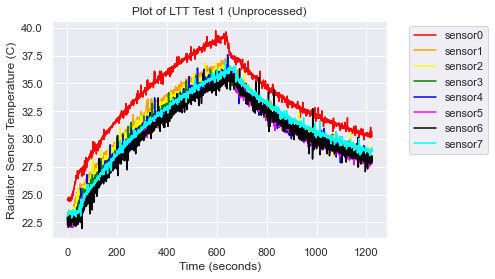

In [288]:
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 0'], label="sensor0", color='red')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 1'], label="sensor1", color='orange')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 2'], label="sensor2", color='yellow')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 3'], label="sensor3", color='green')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 4'], label="sensor4", color='blue')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 5'], label="sensor5", color='magenta')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 6'], label="sensor6", color='black')
plt.plot(ltt_test_1_filtered['TIME'], ltt_test_1_filtered['Sensor 7'], label="sensor7", color='cyan')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('Plot of LTT Test 1 (Unprocessed)')
plt.show()

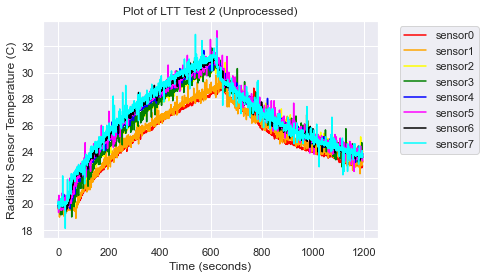

In [289]:
sen1, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 0'], label="sensor0", color='red')
sen2, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 1'], label="sensor1", color='orange')
sen3, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 2'], label="sensor2", color='yellow')
sen4, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 3'], label="sensor3", color='green')
sen5, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 4'], label="sensor4", color='blue')
sen6, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 5'], label="sensor5", color='magenta')
sen7, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 6'], label="sensor6", color='black')
sen8, = plt.plot(ltt_test_2_filtered['Time'], ltt_test_2_filtered['Sensor 7'], label="sensor7", color='cyan')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('Plot of LTT Test 2 (Unprocessed)')
plt.show()

The data shown in test 1 and test 2 are noisy, but not extremely so. Filtering out the invalid values also does not strip out a significant chunk of the data. These two points combined with a large amount of samples means that LOESS smoothing is a good candidate to try and clean the data with so we can try and get a clearer image of the data. Since its quite hard to tell what the exact trends are with the data at this point in time. A quick plot of the raw data also shows that there are no extreme outliers.

Next, explore test 3 which was unused and deduct what they were trying to do with this test.


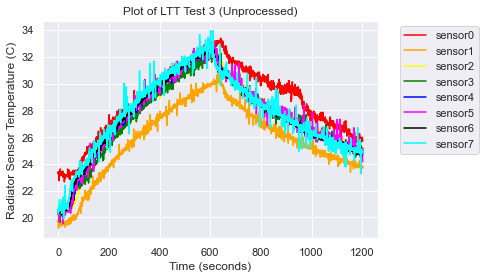

In [290]:
sen1, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 0'], label="sensor0", color='red')
sen2, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 1'], label="sensor1", color='orange')
sen3, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 2'], label="sensor2", color='yellow')
sen4, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 3'], label="sensor3", color='green')
sen5, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 4'], label="sensor4", color='blue')
sen6, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 5'], label="sensor5", color='magenta')
sen7, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 6'], label="sensor6", color='black')
sen8, = plt.plot(ltt_test_3_filtered['Time'], ltt_test_3_filtered['Sensor 7'], label="sensor7", color='cyan')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('Plot of LTT Test 3 (Unprocessed)') #Follows a similar shape to test 2, perhaps this was a second run of their test 2 (coolest rad gets air first)
plt.show()

In [291]:
lowess_smoothed_sensor_0 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 0'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_1 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 1'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_2 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 2'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_3 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 3'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_4 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 4'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_5 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 5'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_6 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 6'], ltt_test_1_filtered['TIME'], frac=0.01)
lowess_smoothed_sensor_7 = sm.nonparametric.lowess(ltt_test_1_filtered['Sensor 7'], ltt_test_1_filtered['TIME'], frac=0.01)

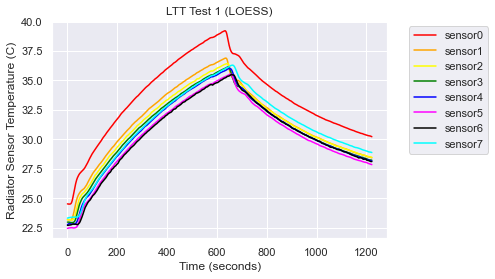

In [292]:
smooth1, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_0[:, 1], label="sensor0", color='red')
smooth2, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_1[:, 1], label="sensor1", color='orange')
smooth3, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_2[:, 1], label="sensor2", color='yellow')
smooth4, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_3[:, 1], label="sensor3", color='green')
smooth5, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_4[:, 1], label="sensor4", color='blue')
smooth6, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_5[:, 1], label="sensor5", color='magenta')
smooth7, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_6[:, 1], label="sensor6", color='black')
smooth8, = plt.plot(ltt_test_1_filtered['TIME'], lowess_smoothed_sensor_7[:, 1], label="sensor7", color='cyan')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('LTT Test 1 (LOESS)')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('orange')
leg.legendHandles[2].set_color('yellow')
leg.legendHandles[3].set_color('green')
leg.legendHandles[4].set_color('blue')
leg.legendHandles[5].set_color('magenta')
leg.legendHandles[6].set_color('black')
leg.legendHandles[7].set_color('cyan')
plt.show()

LTT Test 1 already showed a large change in temperature going from the first radiator to the second, meaning that the first radiator does the most cooling, which is in line with their results. This LOESS smoothed version is clearer in showing it's effects.
The smoothed version actually shows the effect of heat soak more clearly, where sensor 7 is at a higher temperature than ones behind it, meaning that the temperature has increased.

Now we will repeat for tests 2 and 3.

In [293]:
lowess_smoothed_sensor_test2_0 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 0'], ltt_test_2_filtered['Time'], frac=0.02)
lowess_smoothed_sensor_test2_1 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 1'], ltt_test_2_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test2_2 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 2'], ltt_test_2_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test2_3 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 3'], ltt_test_2_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test2_4 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 4'], ltt_test_2_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test2_5 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 5'], ltt_test_2_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test2_6 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 6'], ltt_test_2_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test2_7 = sm.nonparametric.lowess(ltt_test_2_filtered['Sensor 7'], ltt_test_2_filtered['Time'], frac=0.01)

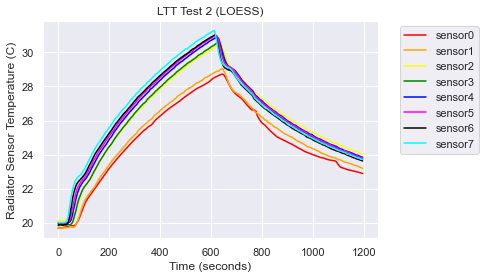

In [294]:
smooth1_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_0[:, 1], label="sensor0", color='red')
smooth2_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_1[:, 1], label="sensor1", color='orange')
smooth3_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_2[:, 1], label="sensor2", color='yellow')
smooth4_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_3[:, 1], label="sensor3", color='green')
smooth5_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_4[:, 1], label="sensor4", color='blue')
smooth6_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_5[:, 1], label="sensor5", color='magenta')
smooth7_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_6[:, 1], label="sensor6", color='black')
smooth8_test2, = plt.plot(ltt_test_2_filtered['Time'], lowess_smoothed_sensor_test2_7[:, 1], label="sensor7", color='cyan')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('LTT Test 2 (LOESS)')
plt.show()

In [295]:
lowess_smoothed_sensor_test3_0 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 0'], ltt_test_3_filtered['Time'], frac=0.02)
lowess_smoothed_sensor_test3_1 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 1'], ltt_test_3_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test3_2 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 2'], ltt_test_3_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test3_3 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 3'], ltt_test_3_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test3_4 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 4'], ltt_test_3_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test3_5 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 5'], ltt_test_3_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test3_6 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 6'], ltt_test_3_filtered['Time'], frac=0.01)
lowess_smoothed_sensor_test3_7 = sm.nonparametric.lowess(ltt_test_3_filtered['Sensor 7'], ltt_test_3_filtered['Time'], frac=0.01)

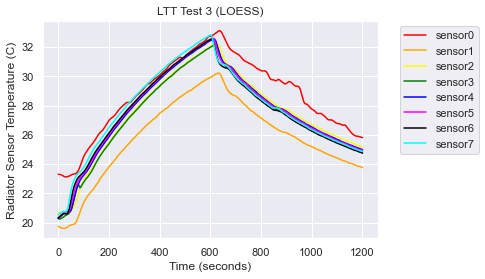

In [296]:
smooth1_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_0[:, 1], label="sensor0", color='red')
smooth2_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_1[:, 1], label="sensor1", color='orange')
smooth3_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_2[:, 1], label="sensor2", color='yellow')
smooth4_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_3[:, 1], label="sensor3", color='green')
smooth5_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_4[:, 1], label="sensor4", color='blue')
smooth6_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_5[:, 1], label="sensor5", color='magenta')
smooth7_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_6[:, 1], label="sensor6", color='black')
smooth8_test3, = plt.plot(ltt_test_3_filtered['Time'], lowess_smoothed_sensor_test3_7[:, 1], label="sensor7", color='cyan')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('LTT Test 3 (LOESS)')
plt.show()

The LTT data had many plot points and a reasonable amount of noise, so using LOESS was probably fine. As an experiment, lets use Kalman smoothing and see if the conclusions made about the data are still the same.

In [297]:
kalman_data = ltt_test_1_filtered[['Sensor 0', 'Sensor 0 RA']]
initial_state = kalman_data.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed, _ = kf.smooth(kalman_data)

kalman_data_sen1 = ltt_test_1_filtered[['Sensor 1', 'Sensor 1 RA']]
initial_state = kalman_data_sen1.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen1, _ = kf.smooth(kalman_data_sen1)

kalman_data_sen2 = ltt_test_1_filtered[['Sensor 2', 'Sensor 2 RA']]
initial_state = kalman_data_sen2.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen2, _ = kf.smooth(kalman_data_sen2)

kalman_data_sen3 = ltt_test_1_filtered[['Sensor 3', 'Sensor 3 RA']]
initial_state = kalman_data_sen3.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen3, _ = kf.smooth(kalman_data_sen3)

kalman_data_sen4 = ltt_test_1_filtered[['Sensor 4', 'Sensor 4 RA']]
initial_state = kalman_data_sen4.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen4, _ = kf.smooth(kalman_data_sen4)

kalman_data_sen5 = ltt_test_1_filtered[['Sensor 5', 'Sensor 5 RA']]
initial_state = kalman_data_sen5.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen5, _ = kf.smooth(kalman_data_sen5)

kalman_data_sen6 = ltt_test_1_filtered[['Sensor 6', 'Sensor 6 RA']]
initial_state = kalman_data_sen6.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen6, _ = kf.smooth(kalman_data_sen6)

kalman_data_sen7 = ltt_test_1_filtered[['Sensor 7', 'Sensor 7 RA']]
initial_state = kalman_data_sen7.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_sen7, _ = kf.smooth(kalman_data_sen7)

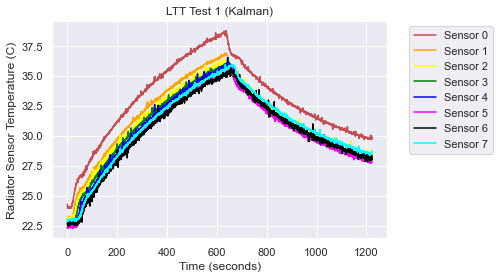

In [298]:
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed[:, 0], color='r', label="Sensor 0")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen1[:, 0], color='orange', label="Sensor 1")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen2[:, 0], color='yellow', label="Sensor 2")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen3[:, 0], color='green', label="Sensor 3")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen4[:, 0], color='blue', label="Sensor 4")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen5[:, 0], color='magenta', label="Sensor 5")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen6[:, 0], color='black', label="Sensor 6")
plt.plot(ltt_test_1_filtered['TIME'], kalman_smoothed_sen7[:, 0], color='cyan', label="Sensor 7")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('LTT Test 1 (Kalman)')
plt.show()

In [299]:
kalman_data_test2 = ltt_test_2_filtered[['Sensor 0', 'Sensor 0 RA']]
initial_state = kalman_data_test2.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2, _ = kf.smooth(kalman_data_test2)

kalman_data_test2_sen1 = ltt_test_2_filtered[['Sensor 1', 'Sensor 1 RA']]
initial_state = kalman_data_test2_sen1.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen1, _ = kf.smooth(kalman_data_test2_sen1)

kalman_data_test2_sen2 = ltt_test_2_filtered[['Sensor 2', 'Sensor 2 RA']]
initial_state = kalman_data_test2_sen2.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen2, _ = kf.smooth(kalman_data_test2_sen2)

kalman_data_test2_sen3 = ltt_test_2_filtered[['Sensor 3', 'Sensor 3 RA']]
initial_state = kalman_data_test2_sen3.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen3, _ = kf.smooth(kalman_data_test2_sen3)

kalman_data_test2_sen4 = ltt_test_2_filtered[['Sensor 4', 'Sensor 4 RA']]
initial_state = kalman_data_test2_sen4.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen4, _ = kf.smooth(kalman_data_test2_sen4)

kalman_data_test2_sen5 = ltt_test_2_filtered[['Sensor 5', 'Sensor 5 RA']]
initial_state = kalman_data_test2_sen5.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen5, _ = kf.smooth(kalman_data_test2_sen5)

kalman_data_test2_sen6 = ltt_test_2_filtered[['Sensor 6', 'Sensor 6 RA']]
initial_state = kalman_data_test2_sen6.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen6, _ = kf.smooth(kalman_data_test2_sen6)

kalman_data_test2_sen7 = ltt_test_2_filtered[['Sensor 7', 'Sensor 7 RA']]
initial_state = kalman_data_test2_sen7.iloc[0]
observation_covariance = np.diag([0.9,0.5]) ** 2
transition_covariance = np.diag([0.9,0.5]) ** 2
transition = [[0.55, 0.455], [0.55, 0.455]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test2_sen7, _ = kf.smooth(kalman_data_test2_sen7)

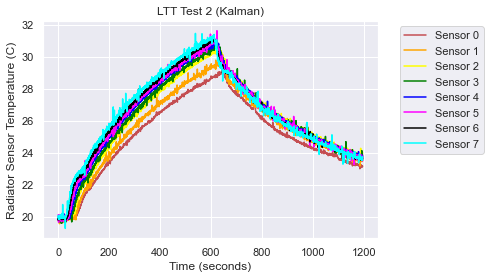

In [300]:
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2[:, 0], color='r', label="Sensor 0")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen1[:, 0], color='orange', label="Sensor 1")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen2[:, 0], color='yellow', label="Sensor 2")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen3[:, 0], color='green', label="Sensor 3")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen4[:, 0], color='blue', label="Sensor 4")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen5[:, 0], color='magenta', label="Sensor 5")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen6[:, 0], color='black', label="Sensor 6")
plt.plot(ltt_test_2_filtered['Time'], kalman_smoothed_test2_sen7[:, 0], color='cyan', label="Sensor 7")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('LTT Test 2 (Kalman)')
plt.show()

In [301]:
kalman_data_test3 = ltt_test_3_filtered[['Sensor 0']]
initial_state = kalman_data_test3.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3, _ = kf.smooth(kalman_data_test3)

kalman_data_test3_sen1 = ltt_test_3_filtered[['Sensor 1']]
initial_state = kalman_data_test3_sen1.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen1, _ = kf.smooth(kalman_data_test3_sen1)

kalman_data_test3_sen2 = ltt_test_3_filtered[['Sensor 2']]
initial_state = kalman_data_test3_sen2.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen2, _ = kf.smooth(kalman_data_test3_sen2)

kalman_data_test3_sen3 = ltt_test_3_filtered[['Sensor 3']]
initial_state = kalman_data_test3_sen3.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen3, _ = kf.smooth(kalman_data_test3_sen3)

kalman_data_test3_sen4 = ltt_test_3_filtered[['Sensor 4']]
initial_state = kalman_data_test3_sen4.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen4, _ = kf.smooth(kalman_data_test3_sen4)

kalman_data_test3_sen5 = ltt_test_3_filtered[['Sensor 5']]
initial_state = kalman_data_test3_sen5.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen5, _ = kf.smooth(kalman_data_test3_sen5)

kalman_data_test3_sen6 = ltt_test_3_filtered[['Sensor 6']]
initial_state = kalman_data_test3_sen6.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen6, _ = kf.smooth(kalman_data_test3_sen6)

kalman_data_test3_sen7 = ltt_test_3_filtered[['Sensor 7']]
initial_state = kalman_data_test3_sen7.iloc[0]
observation_covariance = np.diag([0.75]) ** 2
transition_covariance = np.diag([0.15]) ** 2
transition = [[0.9999]]
kf = KalmanFilter(initial_state_mean=initial_state, initial_state_covariance=observation_covariance,observation_covariance=observation_covariance
    ,transition_covariance= transition_covariance, transition_matrices=transition)
kalman_smoothed_test3_sen7, _ = kf.smooth(kalman_data_test3_sen7)

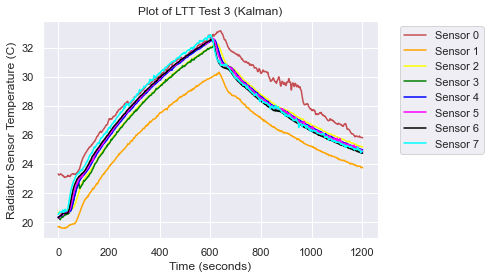

In [302]:
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3[:, 0], color='r', label="Sensor 0")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen1[:, 0], color='orange', label="Sensor 1")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen2[:, 0], color='yellow', label="Sensor 2")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen3[:, 0], color='green', label="Sensor 3")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen4[:, 0], color='blue', label="Sensor 4")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen5[:, 0], color='magenta', label="Sensor 5")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen6[:, 0], color='black', label="Sensor 6")
plt.plot(ltt_test_3_filtered['Time'], kalman_smoothed_test3_sen7[:, 0], color='cyan', label="Sensor 7")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('Plot of LTT Test 3 (Kalman)')
plt.show()

<h1> Part 1.1: Delta T in Tests 1 and 2. </h1>
In this subsection we will use the Delta T metric used by LTT, but applied to the earlier tests as a function of change in temperature between the coolest radiators and the others to find the point where more radiators does not add more cooling.

<h2> Test #1 </h2>

In [303]:
s0 = pd.DataFrame(lowess_smoothed_sensor_0, columns=['time', 'Sensor 0'])
s1 = pd.DataFrame(lowess_smoothed_sensor_1, columns=['time', 'Sensor 1'])
s2 = pd.DataFrame(lowess_smoothed_sensor_2, columns=['time', 'Sensor 2'])
s3 = pd.DataFrame(lowess_smoothed_sensor_3, columns=['time', 'Sensor 3'])
s4 = pd.DataFrame(lowess_smoothed_sensor_4, columns=['time', 'Sensor 4'])
s5 = pd.DataFrame(lowess_smoothed_sensor_5, columns=['time', 'Sensor 5'])
s6 = pd.DataFrame(lowess_smoothed_sensor_6, columns=['time', 'Sensor 6'])
s7 = pd.DataFrame(lowess_smoothed_sensor_7, columns=['time', 'Sensor 7'])
loess_test_1_delta_t = s0.join(s1['Sensor 1']).join(s2['Sensor 2']).join(s3['Sensor 3']).join(s4['Sensor 4']).join(s5['Sensor 5']).join(s6['Sensor 6']).join(s7['Sensor 7'])

In [304]:
loess_test_1_delta_t['s1 - s0'] = loess_test_1_delta_t['Sensor 1'] - loess_test_1_delta_t['Sensor 0'] #Final minus initial for a delta
loess_test_1_delta_t['s2 - s0'] = loess_test_1_delta_t['Sensor 2'] - loess_test_1_delta_t['Sensor 0']
loess_test_1_delta_t['s3 - s0'] = loess_test_1_delta_t['Sensor 3'] - loess_test_1_delta_t['Sensor 0']
loess_test_1_delta_t['s4 - s0'] = loess_test_1_delta_t['Sensor 4'] - loess_test_1_delta_t['Sensor 0']
loess_test_1_delta_t['s5 - s0'] = loess_test_1_delta_t['Sensor 5'] - loess_test_1_delta_t['Sensor 0']
loess_test_1_delta_t['s6 - s0'] = loess_test_1_delta_t['Sensor 6'] - loess_test_1_delta_t['Sensor 0']
loess_test_1_delta_t['s7 - s0'] = loess_test_1_delta_t['Sensor 7'] - loess_test_1_delta_t['Sensor 0']

In [305]:
loess_test_1_delta_t

time   Sensor 0   Sensor 1   Sensor 2   Sensor 3   Sensor 4  \
0        0.0  24.522313  23.173592  23.194880  22.975513  22.764750   
1        0.0  24.522313  23.173592  23.194880  22.975513  22.764750   
2        1.0  24.518000  23.173092  23.187543  22.976068  22.780077   
3        1.0  24.518000  23.173092  23.187543  22.976068  22.780077   
4        1.0  24.518000  23.173092  23.187543  22.976068  22.780077   
...      ...        ...        ...        ...        ...        ...   
4883  1221.0  30.237645  28.446329  28.484942  28.237348  28.172109   
4884  1221.0  30.237645  28.446329  28.484942  28.237348  28.172109   
4885  1221.0  30.237645  28.446329  28.484942  28.237348  28.172109   
4886  1222.0  30.227618  28.438859  28.482693  28.234313  28.167046   
4887  1222.0  30.227618  28.438859  28.482693  28.234313  28.167046   

       Sensor 5   Sensor 6   Sensor 7   s1 - s0   s2 - s0   s3 - s0   s4 - s0  \
0     22.439119  22.696061  23.313191 -1.348721 -1.327433 -1.546800 -1.757563   
1     22.439119  22.696061  23.313191 -1.348721 -1.327433 -1.546800 -1.757563   
2     22.447103  22.697552  23.320423 -1.344908 -1.330457 -1.541933 -1.737924   
3     22.447103  22.697552  23.320423 -1.344908 -1.330457 -1.541933 -1.737924   
4     22.447103  22.697552  23.320423 -1.344908 -1.330457 -1.541933 -1.737924   
...         ...        ...        ...       ...       ...       ...       ...   
4883  27.862930  28.115618  28.891338 -1.791316 -1.752703 -2.000297 -2.065536   
4884  27.862930  28.115618  28.891338 -1.791316 -1.752703 -2.000297 -2.065536   
4885  27.862930  28.115618  28.891338 -1.791316 -1.752703 -2.000297 -2.065536   
4886  27.856878  28.115120  28.884314 -1.788759 -1.744926 -1.993305 -2.060572   
4887  27.856878  28.115120  28.884314 -1.788759 -1.744926 -1.993305 -2.060572   

       s5 - s0   s6 - s0   s7 - s0  
0    -2.083194 -1.826252 -1.209122  
1    -2.083194 -1.826252 -1.209122  
2    -2.070898 -1.820448 -1.197577  
3    -2.070898 -1.820448 -1.197577  
4    -2.070898 -1.820448 -1.197577  
...        ...       ...       ...  
4883 -2.374715 -2.122027 -1.346307  
4884 -2.374715 -2.122027 -1.346307  
4885 -2.374715 -2.122027 -1.346307  
4886 -2.370740 -2.112499 -1.343304  
4887 -2.370740 -2.112499 -1.343304  

[4888 rows x 16 columns]

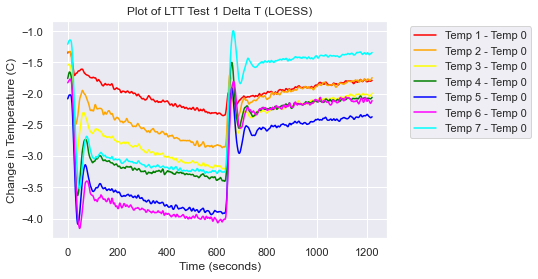

In [306]:
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s1 - s0'], color='red', label="Temp 1 - Temp 0")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s2 - s0'], color='orange', label="Temp 2 - Temp 0")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s3 - s0'], color='yellow', label="Temp 3 - Temp 0")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s4 - s0'], color='green', label="Temp 4 - Temp 0")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s5 - s0'], color='blue', label="Temp 5 - Temp 0")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s6 - s0'], color='magenta', label="Temp 6 - Temp 0")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s7 - s0'], color='cyan', label="Temp 7 - Temp 0")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 1 Delta T (LOESS)')
plt.show()

In [307]:
loess_test_1_delta_t['s0 - s1'] = loess_test_1_delta_t['Sensor 0'] - loess_test_1_delta_t['Sensor 1'] #Final minus initial for a delta
loess_test_1_delta_t['s2 - s1'] = loess_test_1_delta_t['Sensor 2'] - loess_test_1_delta_t['Sensor 1']
loess_test_1_delta_t['s3 - s1'] = loess_test_1_delta_t['Sensor 3'] - loess_test_1_delta_t['Sensor 1']
loess_test_1_delta_t['s4 - s1'] = loess_test_1_delta_t['Sensor 4'] - loess_test_1_delta_t['Sensor 1']
loess_test_1_delta_t['s5 - s1'] = loess_test_1_delta_t['Sensor 5'] - loess_test_1_delta_t['Sensor 1']
loess_test_1_delta_t['s6 - s1'] = loess_test_1_delta_t['Sensor 6'] - loess_test_1_delta_t['Sensor 1']
loess_test_1_delta_t['s7 - s1'] = loess_test_1_delta_t['Sensor 7'] - loess_test_1_delta_t['Sensor 1']

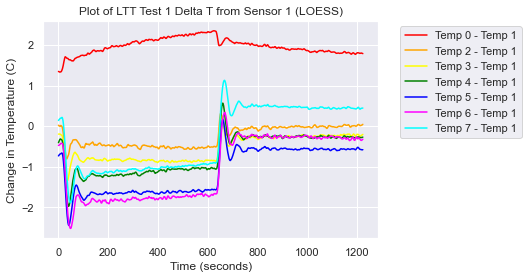

In [308]:
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s0 - s1'], color='red', label="Temp 0 - Temp 1")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s2 - s1'], color='orange', label="Temp 2 - Temp 1")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s3 - s1'], color='yellow', label="Temp 3 - Temp 1")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s4 - s1'], color='green', label="Temp 4 - Temp 1")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s5 - s1'], color='blue', label="Temp 5 - Temp 1")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s6 - s1'], color='magenta', label="Temp 6 - Temp 1")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s7 - s1'], color='cyan', label="Temp 7 - Temp 1")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 1 Delta T from Sensor 1 (LOESS)')
plt.show()

In [309]:
loess_test_1_delta_t['s0 - s2'] = loess_test_1_delta_t['Sensor 0'] - loess_test_1_delta_t['Sensor 2'] #Final minus initial for a delta
loess_test_1_delta_t['s1 - s2'] = loess_test_1_delta_t['Sensor 1'] - loess_test_1_delta_t['Sensor 2']
loess_test_1_delta_t['s3 - s2'] = loess_test_1_delta_t['Sensor 3'] - loess_test_1_delta_t['Sensor 2']
loess_test_1_delta_t['s4 - s2'] = loess_test_1_delta_t['Sensor 4'] - loess_test_1_delta_t['Sensor 2']
loess_test_1_delta_t['s5 - s2'] = loess_test_1_delta_t['Sensor 5'] - loess_test_1_delta_t['Sensor 2']
loess_test_1_delta_t['s6 - s2'] = loess_test_1_delta_t['Sensor 6'] - loess_test_1_delta_t['Sensor 2']
loess_test_1_delta_t['s7 - s2'] = loess_test_1_delta_t['Sensor 7'] - loess_test_1_delta_t['Sensor 2']

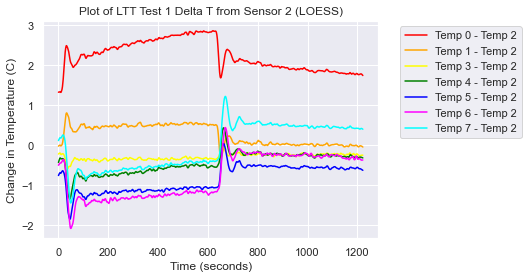

In [310]:
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s0 - s2'], color='red', label="Temp 0 - Temp 2")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s1 - s2'], color='orange', label="Temp 1 - Temp 2")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s3 - s2'], color='yellow', label="Temp 3 - Temp 2")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s4 - s2'], color='green', label="Temp 4 - Temp 2")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s5 - s2'], color='blue', label="Temp 5 - Temp 2")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s6 - s2'], color='magenta', label="Temp 6 - Temp 2")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s7 - s2'], color='cyan', label="Temp 7 - Temp 2")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 1 Delta T from Sensor 2 (LOESS)')
plt.show()

In [311]:
loess_test_1_delta_t['s0 - s3'] = loess_test_1_delta_t['Sensor 0'] - loess_test_1_delta_t['Sensor 3'] #Final minus initial for a delta
loess_test_1_delta_t['s1 - s3'] = loess_test_1_delta_t['Sensor 1'] - loess_test_1_delta_t['Sensor 3']
loess_test_1_delta_t['s2 - s3'] = loess_test_1_delta_t['Sensor 2'] - loess_test_1_delta_t['Sensor 3']
loess_test_1_delta_t['s4 - s3'] = loess_test_1_delta_t['Sensor 4'] - loess_test_1_delta_t['Sensor 3']
loess_test_1_delta_t['s5 - s3'] = loess_test_1_delta_t['Sensor 5'] - loess_test_1_delta_t['Sensor 3']
loess_test_1_delta_t['s6 - s3'] = loess_test_1_delta_t['Sensor 6'] - loess_test_1_delta_t['Sensor 3']
loess_test_1_delta_t['s7 - s3'] = loess_test_1_delta_t['Sensor 7'] - loess_test_1_delta_t['Sensor 3']

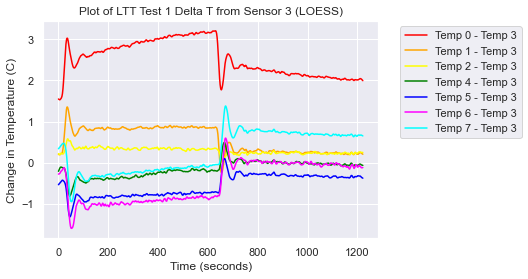

In [312]:
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s0 - s3'], color='red', label="Temp 0 - Temp 3")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s1 - s3'], color='orange', label="Temp 1 - Temp 3")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s2 - s3'], color='yellow', label="Temp 2 - Temp 3")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s4 - s3'], color='green', label="Temp 4 - Temp 3")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s5 - s3'], color='blue', label="Temp 5 - Temp 3")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s6 - s3'], color='magenta', label="Temp 6 - Temp 3")
plt.plot(loess_test_1_delta_t['time'], loess_test_1_delta_t['s7 - s3'], color='cyan', label="Temp 7 - Temp 3")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 1 Delta T from Sensor 3 (LOESS)')
plt.show()

<h3> For Test #1, the graph generated by delta T in Sensor 3 and Sensor 2 are roughly the same, which shows that the difference in temperature does not really change beyond the second radiator. </h3>

<h2> Test #2 </h2>

In [313]:
s0_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_0, columns=['time', 'Sensor 0'])
s1_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_1, columns=['time', 'Sensor 1'])
s2_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_2, columns=['time', 'Sensor 2'])
s3_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_3, columns=['time', 'Sensor 3'])
s4_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_4, columns=['time', 'Sensor 4'])
s5_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_5, columns=['time', 'Sensor 5'])
s6_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_6, columns=['time', 'Sensor 6'])
s7_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_7, columns=['time', 'Sensor 7'])
loess_test_2_delta_t = s0_test2.join(s1_test2['Sensor 1']).join(s2_test2['Sensor 2']).join(s3_test2['Sensor 3']).join(s4_test2['Sensor 4']).join(s5_test2['Sensor 5']).join(s6_test2['Sensor 6']).join(s7_test2['Sensor 7'])

In [314]:
loess_test_2_delta_t['s0 - s7'] = loess_test_2_delta_t['Sensor 0'] - loess_test_2_delta_t['Sensor 7'] #Final minus initial for a delta
loess_test_2_delta_t['s1 - s7'] = loess_test_2_delta_t['Sensor 1'] - loess_test_2_delta_t['Sensor 7']
loess_test_2_delta_t['s2 - s7'] = loess_test_2_delta_t['Sensor 2'] - loess_test_2_delta_t['Sensor 7']
loess_test_2_delta_t['s3 - s7'] = loess_test_2_delta_t['Sensor 3'] - loess_test_2_delta_t['Sensor 7']
loess_test_2_delta_t['s4 - s7'] = loess_test_2_delta_t['Sensor 4'] - loess_test_2_delta_t['Sensor 7']
loess_test_2_delta_t['s5 - s7'] = loess_test_2_delta_t['Sensor 5'] - loess_test_2_delta_t['Sensor 7']
loess_test_2_delta_t['s6 - s7'] = loess_test_2_delta_t['Sensor 6'] - loess_test_2_delta_t['Sensor 7']

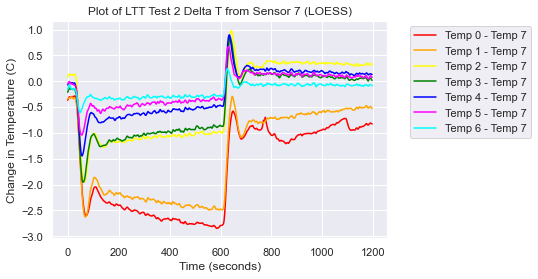

In [315]:
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s0 - s7'], color='red', label="Temp 0 - Temp 7")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s1 - s7'], color='orange', label="Temp 1 - Temp 7")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s2 - s7'], color='yellow', label="Temp 2 - Temp 7")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s3 - s7'], color='green', label="Temp 3 - Temp 7")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s4 - s7'], color='blue', label="Temp 4 - Temp 7")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s5 - s7'], color='magenta', label="Temp 5 - Temp 7")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s6 - s7'], color='cyan', label="Temp 6 - Temp 7")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 2 Delta T from Sensor 7 (LOESS)')
plt.show()

In [316]:
loess_test_2_delta_t['s0 - s6'] = loess_test_2_delta_t['Sensor 0'] - loess_test_2_delta_t['Sensor 6'] #Final minus initial for a delta
loess_test_2_delta_t['s1 - s6'] = loess_test_2_delta_t['Sensor 1'] - loess_test_2_delta_t['Sensor 6']
loess_test_2_delta_t['s2 - s6'] = loess_test_2_delta_t['Sensor 2'] - loess_test_2_delta_t['Sensor 6']
loess_test_2_delta_t['s3 - s6'] = loess_test_2_delta_t['Sensor 3'] - loess_test_2_delta_t['Sensor 6']
loess_test_2_delta_t['s4 - s6'] = loess_test_2_delta_t['Sensor 4'] - loess_test_2_delta_t['Sensor 6']
loess_test_2_delta_t['s5 - s6'] = loess_test_2_delta_t['Sensor 5'] - loess_test_2_delta_t['Sensor 6']
loess_test_2_delta_t['s7 - s6'] = loess_test_2_delta_t['Sensor 7'] - loess_test_2_delta_t['Sensor 6']

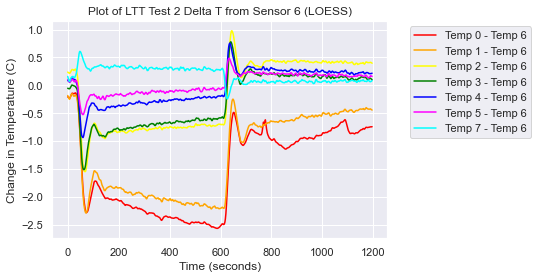

In [317]:
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s0 - s6'], color='red', label="Temp 0 - Temp 6")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s1 - s6'], color='orange', label="Temp 1 - Temp 6")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s2 - s6'], color='yellow', label="Temp 2 - Temp 6")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s3 - s6'], color='green', label="Temp 3 - Temp 6")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s4 - s6'], color='blue', label="Temp 4 - Temp 6")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s5 - s6'], color='magenta', label="Temp 5 - Temp 6")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s7 - s6'], color='cyan', label="Temp 7 - Temp 6")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 2 Delta T from Sensor 6 (LOESS)')
plt.show()

In [318]:
loess_test_2_delta_t['s0 - s5'] = loess_test_2_delta_t['Sensor 0'] - loess_test_2_delta_t['Sensor 5'] #Final minus initial for a delta
loess_test_2_delta_t['s1 - s5'] = loess_test_2_delta_t['Sensor 1'] - loess_test_2_delta_t['Sensor 5']
loess_test_2_delta_t['s2 - s5'] = loess_test_2_delta_t['Sensor 2'] - loess_test_2_delta_t['Sensor 5']
loess_test_2_delta_t['s3 - s5'] = loess_test_2_delta_t['Sensor 3'] - loess_test_2_delta_t['Sensor 5']
loess_test_2_delta_t['s4 - s5'] = loess_test_2_delta_t['Sensor 4'] - loess_test_2_delta_t['Sensor 5']
loess_test_2_delta_t['s6 - s5'] = loess_test_2_delta_t['Sensor 6'] - loess_test_2_delta_t['Sensor 5']
loess_test_2_delta_t['s7 - s5'] = loess_test_2_delta_t['Sensor 7'] - loess_test_2_delta_t['Sensor 5']

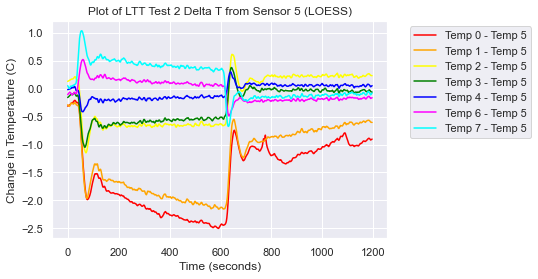

In [319]:
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s0 - s5'], color='red', label="Temp 0 - Temp 5")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s1 - s5'], color='orange', label="Temp 1 - Temp 5")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s2 - s5'], color='yellow', label="Temp 2 - Temp 5")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s3 - s5'], color='green', label="Temp 3 - Temp 5")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s4 - s5'], color='blue', label="Temp 4 - Temp 5")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s6 - s5'], color='magenta', label="Temp 6 - Temp 5")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s7 - s5'], color='cyan', label="Temp 7 - Temp 5")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 2 Delta T from Sensor 5 (LOESS)')
plt.show()

In [320]:
loess_test_2_delta_t['s1 - s0'] = loess_test_2_delta_t['Sensor 1'] - loess_test_2_delta_t['Sensor 0'] #Final minus initial for a delta
loess_test_2_delta_t['s2 - s0'] = loess_test_2_delta_t['Sensor 2'] - loess_test_2_delta_t['Sensor 0']
loess_test_2_delta_t['s3 - s0'] = loess_test_2_delta_t['Sensor 3'] - loess_test_2_delta_t['Sensor 0']
loess_test_2_delta_t['s4 - s0'] = loess_test_2_delta_t['Sensor 4'] - loess_test_2_delta_t['Sensor 0']
loess_test_2_delta_t['s5 - s0'] = loess_test_2_delta_t['Sensor 5'] - loess_test_2_delta_t['Sensor 0']
loess_test_2_delta_t['s6 - s0'] = loess_test_2_delta_t['Sensor 6'] - loess_test_2_delta_t['Sensor 0']
loess_test_2_delta_t['s7 - s0'] = loess_test_2_delta_t['Sensor 7'] - loess_test_2_delta_t['Sensor 0']

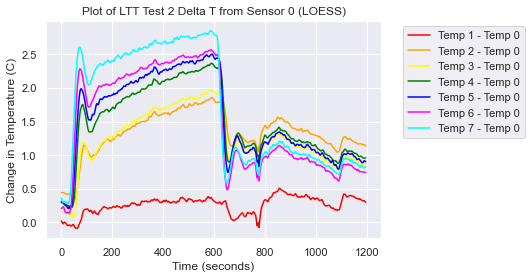

In [321]:
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s1 - s0'], color='red', label="Temp 1 - Temp 0")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s2 - s0'], color='orange', label="Temp 2 - Temp 0")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s3 - s0'], color='yellow', label="Temp 3 - Temp 0")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s4 - s0'], color='green', label="Temp 4 - Temp 0")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s5 - s0'], color='blue', label="Temp 5 - Temp 0")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s6 - s0'], color='magenta', label="Temp 6 - Temp 0")
plt.plot(loess_test_2_delta_t['time'], loess_test_2_delta_t['s7 - s0'], color='cyan', label="Temp 7 - Temp 0")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Change in Temperature (C)')
plt.title('Plot of LTT Test 2 Delta T from Sensor 0 (LOESS)')
plt.show()

<h3> Here we notice the same trend, where the diminishing returns of adding additional radiators shows as the delta T graphs not changing, which indicates a lack of effect. </h3>

<h1> Part 2: Statistical Tests </h1>
In this part we will use attempt to determine if the means are different between the different sensors and Post Hoc analysis to determine whether having multiple radiators in a water cooling configuration is worth it.

In [322]:
ltt_test_1_filtered.describe()

Sensor 0     Sensor 1     Sensor 2     Sensor 3     Sensor 4  \
count  4888.000000  4888.000000  4888.000000  4888.000000  4888.000000   
mean     33.500550    31.523998    31.257946    30.969773    30.812952   
std       3.365639     3.181978     3.140712     3.150670     3.233303   
min      24.410000    22.570000    22.050000    22.750000    22.050000   
25%      31.140000    29.310000    29.210000    28.940000    28.850000   
50%      33.480000    31.510000    31.320000    31.040000    30.860000   
75%      36.180000    34.140000    33.760000    33.480000    33.380000   
max      39.730000    37.180000    36.880000    37.280000    37.580000   

          Sensor 5     Sensor 6     Sensor 7  Sensor 0 RA  Sensor 1 RA  ...  \
count  4888.000000  4888.000000  4888.000000  4888.000000  4888.000000  ...   
mean     30.406565    30.482136    31.209491    32.501702    31.525057  ...   
std       3.197551     3.219698     3.239094     3.362294     3.179113  ...   
min      22.050000    21.960000    22.920000    23.470000    22.950000  ...   
25%      28.490000    28.670000    29.400000    30.170000    29.340000  ...   
50%      30.490000    30.680000    31.410000    32.450000    31.480000  ...   
75%      32.910000    33.025000    33.760000    35.210000    34.110000  ...   
max      36.380000    36.280000    36.980000    38.380000    37.050000  ...   

       Sensor 7 RA trimmed for comparison  Sensor 0 RA.1  Sensor 1 RA .1  \
count                         4888.000000    4888.000000     4888.000000   
mean                            27.612975      32.504032       30.527216   
std                              3.232399       3.357605        3.174815   
min                             19.670000      23.490000       22.060000   
25%                             25.810000      30.160000       28.340000   
50%                             27.790000      32.450000       30.485000   
75%                             30.160000      35.210000       33.100000   
max                             32.780000      38.340000       35.980000   

       Sensor 2 RA .1  Sensor 3 RA .1  Sensor 4 RA.1  Sensor 5 RA .1  \
count     4888.000000     4888.000000    4888.000000     4888.000000   
mean        30.261234       29.973032      29.816264       29.409951   
std          3.131192        3.143392       3.224460        3.190708   
min         21.950000       21.870000      21.680000       21.370000   
25%         28.210000       27.977500      27.860000       27.500000   
50%         30.300000       30.020000      29.830000       29.520000   
75%         32.790000       32.490000      32.370000       31.930000   
max         35.510000       35.370000      35.260000       34.620000   

       Sensor 6 RA.1  Sensor 7 RA.1      TIME_RA  
count    4888.000000    4888.000000  4888.000000  
mean       29.485499      30.212975   610.875000  
std         3.205675       3.232399   352.797097  
min        21.560000      22.270000     0.000000  
25%        27.680000      28.410000   305.437500  
50%        29.650000      30.390000   610.875000  
75%        32.040000      32.760000   916.312500  
max        34.640000      35.380000  1221.750000  

[8 rows x 27 columns]

In [323]:
s0 = pd.DataFrame(lowess_smoothed_sensor_0, columns=['time', 'Sensor 0'])
s1 = pd.DataFrame(lowess_smoothed_sensor_1, columns=['time', 'Sensor 1'])
s2 = pd.DataFrame(lowess_smoothed_sensor_2, columns=['time', 'Sensor 2'])
s3 = pd.DataFrame(lowess_smoothed_sensor_3, columns=['time', 'Sensor 3'])
s4 = pd.DataFrame(lowess_smoothed_sensor_4, columns=['time', 'Sensor 4'])
s5 = pd.DataFrame(lowess_smoothed_sensor_5, columns=['time', 'Sensor 5'])
s6 = pd.DataFrame(lowess_smoothed_sensor_6, columns=['time', 'Sensor 6'])
s7 = pd.DataFrame(lowess_smoothed_sensor_7, columns=['time', 'Sensor 7'])

In [324]:
s1

time   Sensor 1
0        0.0  23.173592
1        0.0  23.173592
2        1.0  23.173092
3        1.0  23.173092
4        1.0  23.173092
...      ...        ...
4883  1221.0  28.446329
4884  1221.0  28.446329
4885  1221.0  28.446329
4886  1222.0  28.438859
4887  1222.0  28.438859

[4888 rows x 2 columns]

In [325]:
loess_test_1 = s0.join(s1['Sensor 1']).join(s2['Sensor 2']).join(s3['Sensor 3']).join(s4['Sensor 4']).join(s5['Sensor 5']).join(s6['Sensor 6']).join(s7['Sensor 7'])

In [326]:
loess_test_1

time   Sensor 0   Sensor 1   Sensor 2   Sensor 3   Sensor 4  \
0        0.0  24.522313  23.173592  23.194880  22.975513  22.764750   
1        0.0  24.522313  23.173592  23.194880  22.975513  22.764750   
2        1.0  24.518000  23.173092  23.187543  22.976068  22.780077   
3        1.0  24.518000  23.173092  23.187543  22.976068  22.780077   
4        1.0  24.518000  23.173092  23.187543  22.976068  22.780077   
...      ...        ...        ...        ...        ...        ...   
4883  1221.0  30.237645  28.446329  28.484942  28.237348  28.172109   
4884  1221.0  30.237645  28.446329  28.484942  28.237348  28.172109   
4885  1221.0  30.237645  28.446329  28.484942  28.237348  28.172109   
4886  1222.0  30.227618  28.438859  28.482693  28.234313  28.167046   
4887  1222.0  30.227618  28.438859  28.482693  28.234313  28.167046   

       Sensor 5   Sensor 6   Sensor 7  
0     22.439119  22.696061  23.313191  
1     22.439119  22.696061  23.313191  
2     22.447103  22.697552  23.320423  
3     22.447103  22.697552  23.320423  
4     22.447103  22.697552  23.320423  
...         ...        ...        ...  
4883  27.862930  28.115618  28.891338  
4884  27.862930  28.115618  28.891338  
4885  27.862930  28.115618  28.891338  
4886  27.856878  28.115120  28.884314  
4887  27.856878  28.115120  28.884314  

[4888 rows x 9 columns]

In [327]:
stats.normaltest(loess_test_1['Sensor 0']).pvalue

8.776199078294899e-26

It is not a normal distribution for the sensor values, so that is one of the assumptions of ANOVA not satisfied.

In [328]:
#Show that the assumption that the variances are the same
s0_s1 = stats.levene(loess_test_1['Sensor 0'], loess_test_1['Sensor 1']).pvalue
s1_s2 = stats.levene(loess_test_1['Sensor 1'], loess_test_1['Sensor 2']).pvalue
s2_s3 = stats.levene(loess_test_1['Sensor 2'], loess_test_1['Sensor 3']).pvalue
s3_s4 = stats.levene(loess_test_1['Sensor 3'], loess_test_1['Sensor 4']).pvalue
s4_s5 = stats.levene(loess_test_1['Sensor 4'], loess_test_1['Sensor 5']).pvalue
s5_s6 = stats.levene(loess_test_1['Sensor 5'], loess_test_1['Sensor 6']).pvalue
s6_s7 = stats.levene(loess_test_1['Sensor 6'], loess_test_1['Sensor 7']).pvalue
#... and more pairs, but a contradiction to the assumption has been found already.


In [329]:
s0_s1

5.3726641483824996e-05

The groups do not have equal variance because the null hypothesis of Levene's test is that the variance is equal, and sensor 0 to sensor 1 having p < 0.05 means we must reject that null hypothesis. The Krusal-Wallis test allows us to test the null hypothesis that each population has an equal median.

In [330]:
#Kruskal-Wallis for LTT Test 1 using LOESS smoothed data
kruskal_test1_loess = stats.kruskal(loess_test_1['Sensor 0'],loess_test_1['Sensor 1'],loess_test_1['Sensor 2'],loess_test_1['Sensor 3'],loess_test_1['Sensor 4'],
loess_test_1['Sensor 5'],loess_test_1['Sensor 6'],loess_test_1['Sensor 7'])

In [331]:
print(kruskal_test1_loess)

KruskalResult(statistic=2620.8455408868945, pvalue=0.0)


In [332]:
#The difference between the means was found to be significant, so we can do a post hoc analysis.
data_t1_loess = pd.DataFrame({'s0':loess_test_1['Sensor 0'],'s1':loess_test_1['Sensor 1'],'s2':loess_test_1['Sensor 2'],'s3':loess_test_1['Sensor 3'],'s4':loess_test_1['Sensor 4'],'s5':loess_test_1['Sensor 5'],'s6':loess_test_1['Sensor 6'],'s7':loess_test_1['Sensor 7'],})
data_t1_loess_melt = pd.melt(data_t1_loess)

In [333]:
posthoc = pairwise_tukeyhsd(
    data_t1_loess_melt['value'], data_t1_loess_melt['variable'],
    alpha=0.05)

In [334]:
print(posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    s0     s1  -1.9756  0.001 -2.1725 -1.7786   True
    s0     s2  -2.2427  0.001 -2.4397 -2.0458   True
    s0     s3  -2.5304  0.001 -2.7274 -2.3334   True
    s0     s4  -2.6869  0.001 -2.8839 -2.4899   True
    s0     s5  -3.0924  0.001 -3.2894 -2.8955   True
    s0     s6  -3.0227  0.001 -3.2197 -2.8258   True
    s0     s7  -2.2912  0.001 -2.4882 -2.0942   True
    s1     s2  -0.2672  0.001 -0.4641 -0.0702   True
    s1     s3  -0.5549  0.001 -0.7518 -0.3579   True
    s1     s4  -0.7113  0.001 -0.9083 -0.5144   True
    s1     s5  -1.1169  0.001 -1.3138 -0.9199   True
    s1     s6  -1.0472  0.001 -1.2441 -0.8502   True
    s1     s7  -0.3157  0.001 -0.5126 -0.1187   True
    s2     s3  -0.2877  0.001 -0.4847 -0.0907   True
    s2     s4  -0.4442  0.001 -0.6411 -0.2472   True
    s2     s5  -0.8497  0.001 -1.0467 -0.6527 

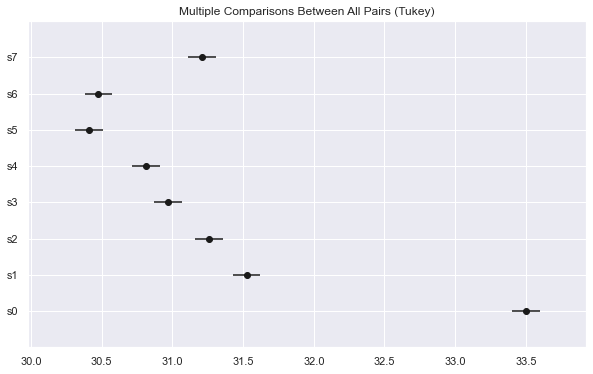

In [335]:
fig = posthoc.plot_simultaneous() #Test 1

<h3> Analysis on LTT Test 1 using raw data. </h3>

In [336]:
#Kruskal Wallis for LTT Test 1 using the raw data
kruskal_test1 = stats.kruskal(ltt_test_1_filtered['Sensor 0'],ltt_test_1_filtered['Sensor 1'],ltt_test_1_filtered['Sensor 2'],ltt_test_1_filtered['Sensor 3'],ltt_test_1_filtered['Sensor 4'],
ltt_test_1_filtered['Sensor 5'],ltt_test_1_filtered['Sensor 6'],ltt_test_1_filtered['Sensor 7'])

In [337]:
print(kruskal_test1)

KruskalResult(statistic=2612.1844905164294, pvalue=0.0)


In [338]:
#The difference between the medians was found to be significant, so we can do a post hoc analysis.
data_t1 = pd.DataFrame({'s0':ltt_test_1_filtered['Sensor 0'],'s1':ltt_test_1_filtered['Sensor 1'],'s2':ltt_test_1_filtered['Sensor 2'],'s3':ltt_test_1_filtered['Sensor 3'],'s4':ltt_test_1_filtered['Sensor 4'],'s5':ltt_test_1_filtered['Sensor 5'],'s6':ltt_test_1_filtered['Sensor 6'],'s7':ltt_test_1_filtered['Sensor 7'],})
data_t1_melt = pd.melt(data_t1)

In [339]:
posthoc = pairwise_tukeyhsd(
    data_t1_melt['value'], data_t1_melt['variable'],
    alpha=0.05)

In [340]:
print(posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    s0     s1  -1.9766  0.001 -2.1738 -1.7793   True
    s0     s2  -2.2426  0.001 -2.4398 -2.0454   True
    s0     s3  -2.5308  0.001  -2.728 -2.3336   True
    s0     s4  -2.6876  0.001 -2.8848 -2.4904   True
    s0     s5   -3.094  0.001 -3.2912 -2.8968   True
    s0     s6  -3.0184  0.001 -3.2156 -2.8212   True
    s0     s7  -2.2911  0.001 -2.4883 -2.0938   True
    s1     s2  -0.2661 0.0011 -0.4633 -0.0688   True
    s1     s3  -0.5542  0.001 -0.7514  -0.357   True
    s1     s4   -0.711  0.001 -0.9083 -0.5138   True
    s1     s5  -1.1174  0.001 -1.3147 -0.9202   True
    s1     s6  -1.0419  0.001 -1.2391 -0.8446   True
    s1     s7  -0.3145  0.001 -0.5117 -0.1173   True
    s2     s3  -0.2882  0.001 -0.4854  -0.091   True
    s2     s4   -0.445  0.001 -0.6422 -0.2478   True
    s2     s5  -0.8514  0.001 -1.0486 -0.6542 

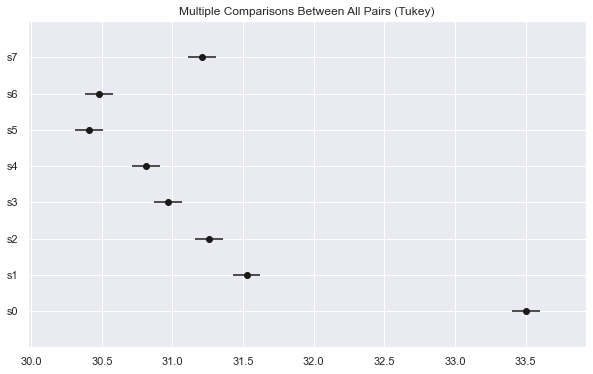

In [341]:
fig = posthoc.plot_simultaneous() # Test 1 raw data

<h3> Testing LTT's Test #2 </h3>

In [342]:
s0_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_0, columns=['time', 'Sensor 0'])
s1_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_1, columns=['time', 'Sensor 1'])
s2_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_2, columns=['time', 'Sensor 2'])
s3_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_3, columns=['time', 'Sensor 3'])
s4_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_4, columns=['time', 'Sensor 4'])
s5_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_5, columns=['time', 'Sensor 5'])
s6_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_6, columns=['time', 'Sensor 6'])
s7_test2 = pd.DataFrame(lowess_smoothed_sensor_test2_7, columns=['time', 'Sensor 7'])

In [343]:
loess_test_2 = s0_test2.join(s1_test2['Sensor 1']).join(s2_test2['Sensor 2']).join(s3_test2['Sensor 3']).join(s4_test2['Sensor 4']).join(s5_test2['Sensor 5']).join(s6_test2['Sensor 6']).join(s7_test2['Sensor 7'])

In [344]:
s0_s1_t2 = stats.levene(loess_test_2['Sensor 0'], loess_test_2['Sensor 1']).pvalue
s1_s2_t2 = stats.levene(loess_test_2['Sensor 1'], loess_test_2['Sensor 2']).pvalue
s2_s3_t2 = stats.levene(loess_test_2['Sensor 2'], loess_test_2['Sensor 3']).pvalue
s3_s4_t2 = stats.levene(loess_test_2['Sensor 3'], loess_test_2['Sensor 4']).pvalue
s4_s5_t2 = stats.levene(loess_test_2['Sensor 4'], loess_test_2['Sensor 5']).pvalue
s5_s6_t2 = stats.levene(loess_test_2['Sensor 5'], loess_test_2['Sensor 6']).pvalue
s6_s7_t2 = stats.levene(loess_test_2['Sensor 6'], loess_test_2['Sensor 7']).pvalue

In [345]:
s0_s1_t2 #showing that ANOVA condition is not satisfied

0.46707584479271813

In [346]:
#Kruskal-Wallis for LTT Test 2 using LOESS smoothed data
kruskal_test2_loess = stats.kruskal(loess_test_2['Sensor 0'],loess_test_2['Sensor 1'],loess_test_2['Sensor 2'],loess_test_2['Sensor 3'],loess_test_2['Sensor 4'],
loess_test_2['Sensor 5'],loess_test_2['Sensor 6'],loess_test_2['Sensor 7'])

In [347]:
print(kruskal_test2_loess)

KruskalResult(statistic=1966.833613621784, pvalue=0.0)


In [348]:
data_t2_loess = pd.DataFrame({'s0':loess_test_2['Sensor 0'],'s1':loess_test_2['Sensor 1'],'s2':loess_test_2['Sensor 2'],'s3':loess_test_2['Sensor 3'],'s4':loess_test_2['Sensor 4'],'s5':loess_test_2['Sensor 5'],'s6':loess_test_2['Sensor 6'],'s7':loess_test_2['Sensor 7'],})
data_t2_loess_melt = pd.melt(data_t2_loess)

In [349]:
posthoc = pairwise_tukeyhsd(
    data_t2_loess_melt['value'], data_t2_loess_melt['variable'],
    alpha=0.05)

In [350]:
print(posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    s0     s1   0.2629  0.001  0.1002 0.4255   True
    s0     s2   1.3366  0.001  1.1739 1.4993   True
    s0     s3   1.2485  0.001  1.0859 1.4112   True
    s0     s4   1.4968  0.001  1.3341 1.6595   True
    s0     s5   1.5499  0.001  1.3872 1.7126   True
    s0     s6   1.5194  0.001  1.3567 1.6821   True
    s0     s7   1.7068  0.001  1.5441 1.8695   True
    s1     s2   1.0738  0.001  0.9111 1.2364   True
    s1     s3   0.9857  0.001   0.823 1.1484   True
    s1     s4   1.2339  0.001  1.0712 1.3966   True
    s1     s5    1.287  0.001  1.1244 1.4497   True
    s1     s6   1.2565  0.001  1.0939 1.4192   True
    s1     s7    1.444  0.001  1.2813 1.6066   True
    s2     s3  -0.0881 0.6983 -0.2508 0.0746  False
    s2     s4   0.1602 0.0574 -0.0025 0.3228  False
    s2     s5   0.2133 0.0018  0.0506  0.376   True
    s2     s

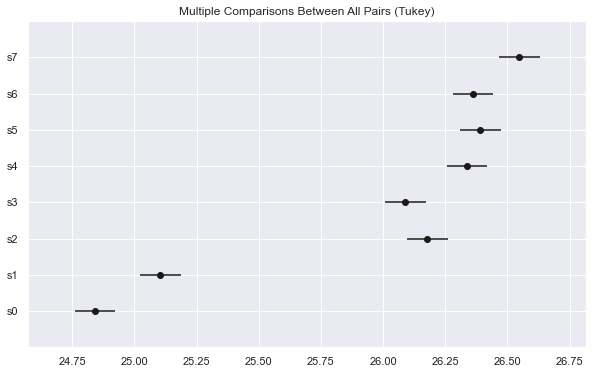

In [351]:
fig = posthoc.plot_simultaneous() #Test 2


<h3> Testing LTT's Test #3 </h3>

In [352]:
s0_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_0, columns=['time', 'Sensor 0'])
s1_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_1, columns=['time', 'Sensor 1'])
s2_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_2, columns=['time', 'Sensor 2'])
s3_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_3, columns=['time', 'Sensor 3'])
s4_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_4, columns=['time', 'Sensor 4'])
s5_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_5, columns=['time', 'Sensor 5'])
s6_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_6, columns=['time', 'Sensor 6'])
s7_test3 = pd.DataFrame(lowess_smoothed_sensor_test3_7, columns=['time', 'Sensor 7'])

In [353]:
loess_test_3 = s0_test3.join(s1_test3['Sensor 1']).join(s2_test3['Sensor 2']).join(s3_test3['Sensor 3']).join(s4_test3['Sensor 4']).join(s5_test3['Sensor 5']).join(s6_test3['Sensor 6']).join(s7_test3['Sensor 7'])

In [354]:
s0_s1_t3 = stats.levene(loess_test_3['Sensor 0'], loess_test_3['Sensor 1']).pvalue
s1_s2_t3 = stats.levene(loess_test_3['Sensor 1'], loess_test_3['Sensor 2']).pvalue
s2_s3_t3 = stats.levene(loess_test_3['Sensor 2'], loess_test_3['Sensor 3']).pvalue
s3_s4_t3 = stats.levene(loess_test_3['Sensor 3'], loess_test_3['Sensor 4']).pvalue
s4_s5_t3 = stats.levene(loess_test_3['Sensor 4'], loess_test_3['Sensor 5']).pvalue
s5_s6_t3 = stats.levene(loess_test_3['Sensor 5'], loess_test_3['Sensor 6']).pvalue
s6_s7_t3 = stats.levene(loess_test_3['Sensor 6'], loess_test_3['Sensor 7']).pvalue

In [355]:
s0_s1_t3 #showing that ANOVA condition is not satisfied

0.20920049886461067

In [356]:
#Kruskal-Wallis for LTT Test 3 using LOESS smoothed data
kruskal_test3_loess = stats.kruskal(loess_test_3['Sensor 0'],loess_test_3['Sensor 1'],loess_test_3['Sensor 2'],loess_test_3['Sensor 3'],loess_test_3['Sensor 4'],
loess_test_3['Sensor 5'],loess_test_3['Sensor 6'],loess_test_3['Sensor 7'])

In [357]:
print(kruskal_test3_loess)

KruskalResult(statistic=2393.2392632451665, pvalue=0.0)


In [358]:
data_t3_loess = pd.DataFrame({'s0':loess_test_3['Sensor 0'],'s1':loess_test_3['Sensor 1'],'s2':loess_test_3['Sensor 2'],'s3':loess_test_3['Sensor 3'],'s4':loess_test_3['Sensor 4'],'s5':loess_test_3['Sensor 5'],'s6':loess_test_3['Sensor 6'],'s7':loess_test_3['Sensor 7'],})
data_t3_loess_melt = pd.melt(data_t3_loess)

In [359]:
posthoc = pairwise_tukeyhsd(
    data_t3_loess_melt['value'], data_t3_loess_melt['variable'],
    alpha=0.05)

In [360]:
print(posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    s0     s1  -2.9062  0.001 -3.0833  -2.729   True
    s0     s2  -1.2274  0.001 -1.4046 -1.0502   True
    s0     s3  -1.3982  0.001 -1.5754 -1.2211   True
    s0     s4  -1.1197  0.001 -1.2969 -0.9425   True
    s0     s5  -1.0931  0.001 -1.2703 -0.9159   True
    s0     s6  -1.1669  0.001 -1.3441 -0.9897   True
    s0     s7  -0.9487  0.001 -1.1259 -0.7715   True
    s1     s2   1.6787  0.001  1.5016  1.8559   True
    s1     s3   1.5079  0.001  1.3307  1.6851   True
    s1     s4   1.7865  0.001  1.6093  1.9637   True
    s1     s5    1.813  0.001  1.6359  1.9902   True
    s1     s6   1.7393  0.001  1.5621  1.9164   True
    s1     s7   1.9575  0.001  1.7803  2.1347   True
    s2     s3  -0.1708 0.0685  -0.348  0.0064  False
    s2     s4   0.1077 0.5776 -0.0694  0.2849  False
    s2     s5   0.1343  0.295 -0.0429  0.3115 

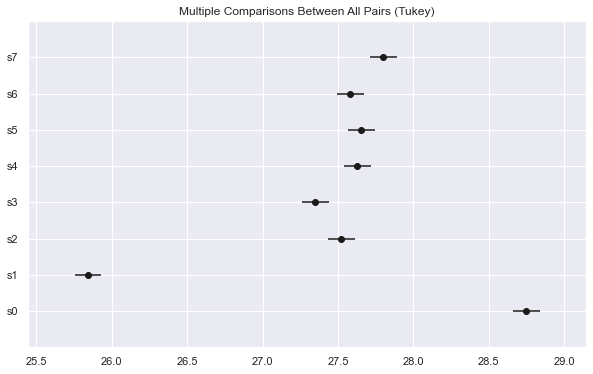

In [361]:
fig = posthoc.plot_simultaneous() #Test 3

<h1> Part 3: Additional Considerations - Looking at LTT's Single and Double Radiator Tests </h1>
In this section, we will examine the remaining tests done by LTT to see if there is any additional information we can glean off of their data.

Test 6 - Not used in video.
Single radiator, 3 sensors. It's important to note that the sensors are just placed in a location in the wind tunnel and is not really associated with that particular radiator besides positioning.

In [362]:
ltt_test_6_filtered = ltt_test_6.dropna()
ltt_test_6_filtered.columns = ['Sensor 0', 'Sensor 1', 'Sensor 2', 'Sensor 0 RA', 'Sensor 1 RA', 'Sensor 2 RA', 'Time']

In [363]:
ltt_test_6_filtered

Sensor 0  Sensor 1  Sensor 2  Sensor 0 RA  Sensor 1 RA  Sensor 2 RA  \
2        25.02     25.02     25.38        24.97        25.08        25.49   
3        24.94     25.02     25.38        24.97        25.05        25.44   
4        25.02     25.02     25.46        24.99        25.02        25.41   
5        24.85     25.02     25.02        24.94        25.02        25.29   
6        24.85     25.11     25.46        24.91        25.05        25.31   
...        ...       ...       ...          ...          ...          ...   
4715     25.82     25.99     26.35        25.85        26.02        26.41   
4716     25.91     26.08     26.53        25.88        26.02        26.44   
4717     25.91     26.08     26.44        25.88        26.05        26.44   
4718     25.82     25.99     26.44        25.88        26.05        26.47   
4719     25.82     26.08     26.44        25.85        26.05        26.44   

         Time  
2        0.00  
3        0.25  
4        0.50  
5        0.75  
6        1.00  
...       ...  
4715  1178.25  
4716  1178.50  
4717  1178.75  
4718  1179.00  
4719  1179.25  

[4718 rows x 7 columns]

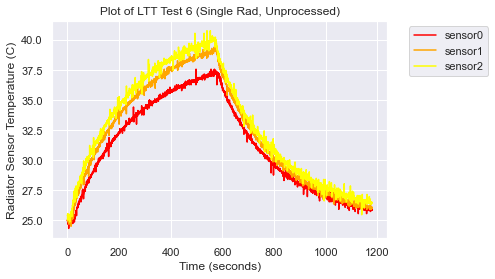

In [364]:
sen1_t6, = plt.plot(ltt_test_6_filtered['Time'], ltt_test_6_filtered['Sensor 0'], label="sensor0", color='red')
sen2_t6, = plt.plot(ltt_test_6_filtered['Time'], ltt_test_6_filtered['Sensor 1'], label="sensor1", color='orange')
sen3_t6, = plt.plot(ltt_test_6_filtered['Time'], ltt_test_6_filtered['Sensor 2'], label="sensor2", color='yellow')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('Plot of LTT Test 6 (Single Rad, Unprocessed)') 
plt.show()

In [365]:
ltt_test_7_filtered = ltt_test_7.dropna()
ltt_test_7_filtered

Time (s)  Sensor 0  Sensor 1  Sensor 0 Rolling Average  \
0         0.00     21.96     22.14                     21.99   
1         0.25     22.05     22.14                     22.02   
2         0.50     21.96     22.31                     22.02   
3         0.75     22.05     22.48                     22.08   
4         1.00     22.05     22.22                     22.05   
...        ...       ...       ...                       ...   
4893   1223.25     23.97     24.06                     24.00   
4894   1223.50     23.97     24.23                     24.00   
4895   1223.75     24.06     25.38                     24.00   
4896   1224.00     23.97     23.97                     24.00   
4897   1224.25     23.97     23.79                     24.03   

      Sensor 1 Rolling Average  Sensor 0 HEAVY RA  Sensor 1 HEAVY RA  \
0                        22.20              22.02              22.20   
1                        22.31              22.05              22.22   
2                        22.34              22.06              22.20   
3                        22.25              22.09              22.16   
4                        22.11              22.09              22.12   
...                        ...                ...                ...   
4893                     24.56              24.01              24.45   
4894                     24.53              24.02              24.35   
4895                     24.38              24.02              24.34   
4896                     24.17              24.02              24.32   
4897                     24.50              24.01              24.39   

      Delta T Heavy RA  Sensor 0.1  Sensor 1.1  Sensor 2  \
0                 0.17       23.18       23.18     23.53   
1                 0.17       23.18       23.27     23.44   
2                 0.13       23.18       23.18     23.44   
3                 0.07       23.18       24.23     23.62   
4                 0.03       23.18       23.27     23.27   
...                ...         ...         ...       ...   
4893              0.44       25.02       25.38     25.55   
4894              0.33       25.11       25.29     25.64   
4895              0.31       25.11       25.20     25.64   
4896              0.30       25.02       25.20     25.55   
4897              0.38       25.11       25.29     25.64   

      Sensor 0 Rolling Average.1  Sensor 1 HEAVY RA.1  Sensor 2 HEAVY RA  \
0                          23.18                23.38              23.45   
1                          23.18                23.38              23.45   
2                          23.23                23.38              23.45   
3                          23.23                23.38              23.45   
4                          23.23                23.23              23.43   
...                          ...                  ...                ...   
4893                       25.08                25.28              25.61   
4894                       25.08                25.26              25.63   
4895                       25.07                25.25              25.61   
4896                       25.07                25.26              25.60   
4897                       25.07                25.28              25.60   

      Delta T Heavy RA.1  
0                   0.27  
1                   0.27  
2                   0.22  
3                   0.22  
4                   0.20  
...                  ...  
4893                0.53  
4894                0.54  
4895                0.54  
4896                0.53  
4897                0.53  

[4898 rows x 15 columns]

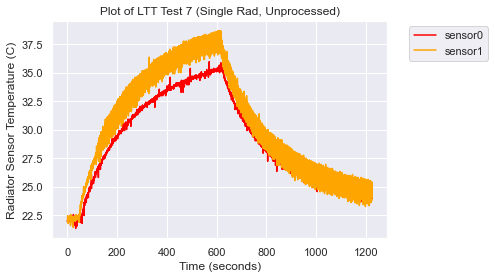

In [366]:
sen1_t6, = plt.plot(ltt_test_7_filtered['Time (s)'], ltt_test_7_filtered['Sensor 0'], label="sensor0", color='red')
sen2_t6, = plt.plot(ltt_test_7_filtered['Time (s)'], ltt_test_7_filtered['Sensor 1'], label="sensor1", color='orange')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiator Sensor Temperature (C)')
plt.title('Plot of LTT Test 7 (Single Rad, Unprocessed)') 
plt.show()